## Projeto

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

###  Exploring & understanding the features

In [2]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [3]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


#### Normalize the data

In [4]:
# Z-score normalization

# copy the data to a new dataframe
data_frame_fcnc_norm = data_frame_fcnc.copy()
data_frame_bkg_norm = data_frame_bkg.copy()

# normalize the data except the categorical features and the weights
for feature in data_frame_fcnc.columns:
    if feature in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split', 'gen_decay2','gen_decay1', 'gen_xsec']:
        pass
    else: 
        data_frame_fcnc_norm[feature] = (data_frame_fcnc[feature] - data_frame_fcnc[feature].mean()) / data_frame_fcnc[feature].std()
        
for feature in data_frame_bkg.columns:
    if feature in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split','gen_decay2','gen_decay1','gen_xsec']:
        pass
    else:  
        data_frame_bkg_norm[feature] = (data_frame_bkg[feature] - data_frame_bkg[feature].mean()) / data_frame_bkg[feature].std()

### SVMs

#### Data preprocessing 

In [5]:
# Split the data into train, validation and test sets for each dataset

data_frame_fcnc_norm_train = data_frame_fcnc_norm.loc[data_frame_fcnc_norm['gen_split'] == 'train']
data_frame_bkg_norm_train =  data_frame_bkg_norm.loc[data_frame_bkg_norm['gen_split'] == 'train']
a,_ = data_frame_fcnc_norm_train.shape

data_frame_fcnc_norm_test = data_frame_fcnc_norm.loc[data_frame_fcnc_norm['gen_split'] == 'test']
data_frame_bkg_norm_test =  data_frame_bkg_norm.loc[data_frame_bkg_norm['gen_split'] == 'test']

b,_ = data_frame_fcnc_norm_test.shape

data_frame_fcnc_norm_val = data_frame_fcnc_norm.loc[data_frame_fcnc_norm['gen_split'] == 'val']
data_frame_bkg_norm_val =  data_frame_bkg_norm.loc[data_frame_bkg_norm['gen_split'] == 'val']

c,_ = data_frame_fcnc_norm_val.shape


# get 500 points of each dataset and  join the datasets (randomly)
train_fcnc = data_frame_fcnc_norm_train.sample(n=500,random_state=42)
train_bkg = data_frame_bkg_norm_train.sample(n=500,random_state=42)
train = pd.concat([train_fcnc, train_bkg])
train = train.sample(frac=1,random_state=42)

test_fcnc = data_frame_fcnc_norm_test.sample(n=500,random_state=42)
test_bkg = data_frame_bkg_norm_test.sample(n=500,random_state=42)
test= pd.concat([test_fcnc, test_bkg])
test = test.sample(frac=1,random_state=42)

val_fnc = data_frame_fcnc_norm_val.sample(n=500,random_state=42)
val_bkg = data_frame_bkg_norm_val.sample(n=500,random_state=42)
val = pd.concat([val_fnc, val_bkg])
val = val.sample(frac=1,random_state=42)


# get the weights for each dataset
w_train = train[['gen_xsec']]
w_test = test[['gen_xsec']]
w_val = val[['gen_xsec']]


# change the signal and bkg labels to 0 and 1 and get the labels for each dataset

train = train.replace(['signal'], 1)
train= train.replace(['bkg'], 0)
y_train = train[['gen_label']]
x_train = train[['MissingET_MET', 'Jet1_BTag']]

test = test.replace(['signal'], 1)
test= test.replace(['bkg'], 0)
y_test = test[['gen_label']]
x_test = test[['MissingET_MET', 'Jet1_BTag']]

val = val.replace(['signal'], 1)
val= val.replace(['bkg'], 0)
y_val = val[['gen_label']]
x_val = val[['MissingET_MET', 'Jet1_BTag']]



#### Train

In [6]:
# transform y_train into a single array instead of  a dataframe
y_train_arr = np.concatenate( y_train.values, axis=0 )


In [7]:
# Renormalize weights
w_train[y_train_arr == 1] = (w_train[y_train_arr == 1] / w_train[y_train_arr == 1].sum()) * w_train.shape[0] / 2
w_train[y_train_arr == 0] = (w_train[y_train_arr == 0] / w_train[y_train_arr == 0].sum()) * w_train.shape[0] / 2


# Train SMV
clf = svm.SVC(kernel="rbf", probability=True)   
clf.fit(x_train, y_train_arr,sample_weight=w_train.values.ravel())


SVC(probability=True)

#### Validation

In [8]:
# transform y_val into a single array instead of  a dataframe
y_val_arr = np.concatenate( y_val.values, axis=0 )

# Renormalize weights
w_val[y_val_arr == 1] = (w_val[y_val_arr == 1] / w_val[y_val_arr == 1].sum()) * w_val.shape[0] / 2
w_val[y_val_arr == 0] = (w_val[y_val_arr == 0] / w_val[y_val_arr == 0].sum()) * w_val.shape[0] / 2

# Predict
y_val_scores = clf.predict_proba(x_val)
y_val_scores = y_val_scores[:, 1]
y_val_pred = clf.predict(x_val)

# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred, sample_weight=w_val.values.ravel())
auc_score = roc_auc_score(y_val, y_val_scores,sample_weight=w_val.values.ravel())

print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.9598560782165242
ROC AUC Score: 0.9977707447172975


#### Test

In [9]:
# transform y_val into a single array instead of a dataframe
y_test_arr = np.concatenate( y_test.values, axis=0 )

# Renormalize weights
w_test[y_test_arr == 1] = (w_test[y_test_arr == 1] / w_test[y_test_arr == 1].sum()) * w_test.shape[0] / 2
w_test[y_test_arr == 0] = (w_test[y_test_arr == 0] / w_test[y_test_arr == 0].sum()) * w_test.shape[0] / 2

# Predict
y_test_scores = clf.predict_proba(x_test)
y_test_scores = y_test_scores[:, 1]
y_pred = clf.predict(x_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test.values.ravel())
auc_score = roc_auc_score(y_test, y_test_scores, sample_weight=w_test.values.ravel())
print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.9739330841661478
ROC AUC Score: 0.9984658091931088


/tmp/ipykernel_507139/2209573682.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


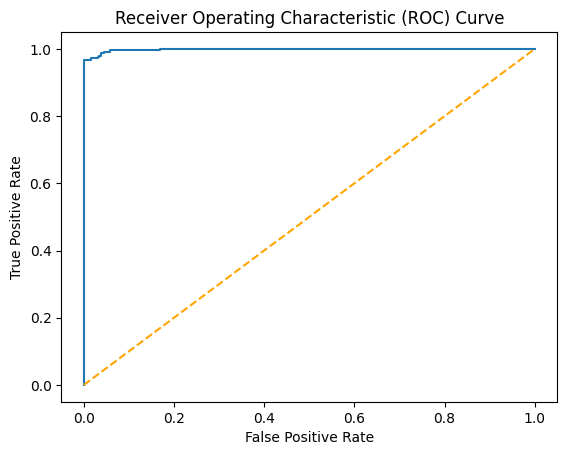

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores, sample_weight=w_test.values.ravel())

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

[4.62705008e+02 3.85761520e+00 9.71891299e-01 1.92799906e+00
 3.15670825e-02 1.16997537e-01 1.08099706e+00 7.30480217e+00
 7.89177063e-03 9.64315669e-01 9.63999528e-01 1.04582572e+00
 7.89177063e-03 1.09105766e-01 0.00000000e+00 1.57835413e-02
 0.00000000e+00 9.63999528e-01 2.09443456e-02 9.63999528e-01
 9.71891299e-01 1.93589083e+00 0.00000000e+00 1.92799906e+00
 3.82114291e+00 8.27669347e+00 5.45444209e-03 0.00000000e+00
 0.00000000e+00 2.93637804e-04]
[7.89177063e-03 0.00000000e+00 0.00000000e+00 7.89177063e-03
 0.00000000e+00 0.00000000e+00 9.71891299e-01 0.00000000e+00
 9.71891299e-01 0.00000000e+00 0.00000000e+00 7.89177063e-03
 7.89177063e-03 9.63999528e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.89177063e-03 9.63999528e-01 0.00000000e+00
 7.89177063e-03 5.16080429e-03 7.89177063e-03 0.00000000e+00
 1.09105766e-01 1.14327122e-01 2.88361162e-02 1.22158341e-01
 1.30525749e-02 4.95680335e+02]


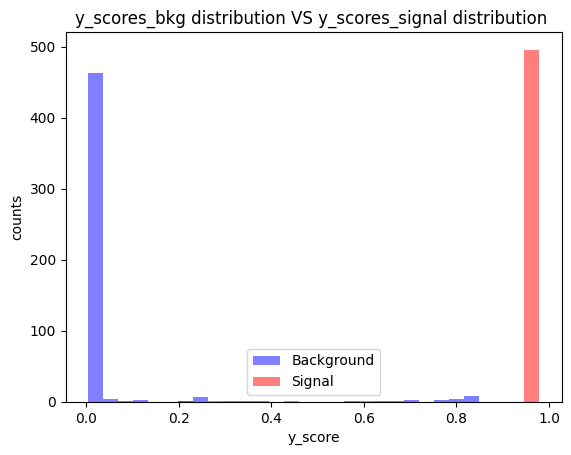

In [11]:
# Plot signal and background distributions for the predicted scores with normalized counts and log scale

num_bins = 30  # Number of bins

# Compute the range for the bins based on the minimum and maximum values of the data
min_value = min(min(y_test_scores[y_test_arr == 0]), min(y_test_scores[y_test_arr == 1]))
max_value = max(max(y_test_scores[y_test_arr == 0]), max(y_test_scores[y_test_arr == 1]))
bin_range = (min_value, max_value)

counts, bins, _ = plt.hist(y_test_scores[y_test_arr == 0], bins=num_bins, range=bin_range,  weights=w_test[y_test_arr==0], alpha=0.5, color='b', label='Background')
counts2, bins2, _ = plt.hist(y_test_scores[y_test_arr == 1], bins=num_bins, range=bin_range,weights=w_test[y_test_arr==0], alpha=0.5, color='r', label='Signal')

print(counts)
print(counts2)

plt.xlabel('y_score')
plt.ylabel('counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

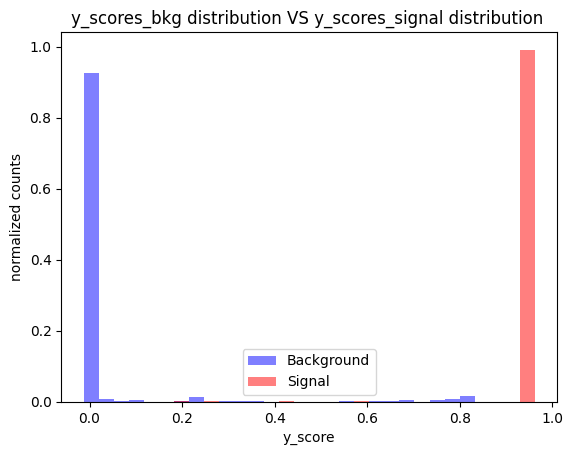

In [12]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

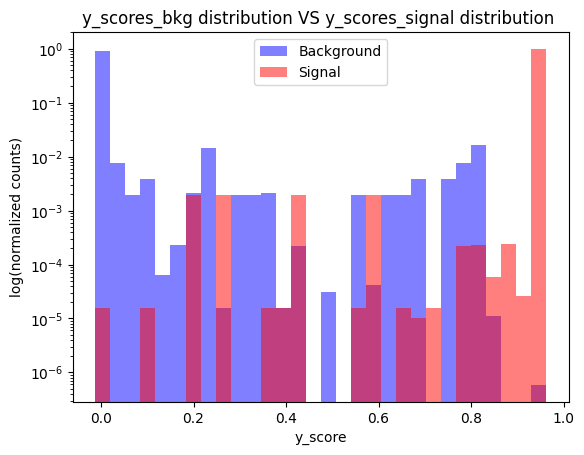

In [13]:
# Normalize the counts
counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('log(normalized counts)')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.yscale('log')
plt.legend()
plt.show()

### Grid search to find the best hyperparameters

In [14]:
# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 0.2, 0.5, 0.7, 1, 2, 5, 7, 10, 20, 50,70, 90, 100, 110, 130, 150, 200, 500, 700, 1000],
    'gamma': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,5,7,10, 'scale'],
    'kernel': ['linear', 'poly', 'rbf']
}

# Create an SVM classifier object
svm_clf = svm.SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)

# Fit the grid search to your training data
grid_search.fit(x_train, y_train_arr, sample_weight=w_train.values.ravel())

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test_arr, sample_weight=w_test.values.ravel())
print("Test Score: ", test_score)

In [ ]:
# Obtain predictions from the best model
y_pred = best_model.predict(x_test)

# Compute accuracy score
accuracy = accuracy_score(y_test_arr, y_pred)
print("Accuracy: ", accuracy)

# Compute predicted probabilities for ROC curve
y_pred_prob = best_model.predict_proba(x_test)[:, 1]

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test_arr, y_pred_prob, sample_weight=w_test.values.ravel())
print("ROC AUC: ", roc_auc)

Accuracy:  0.998
ROC AUC:  1.0


/tmp/ipykernel_1795377/3688770402.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


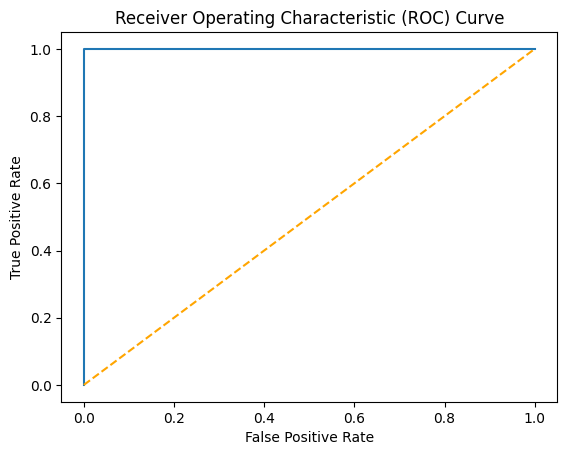

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, sample_weight=w_test.values.ravel())

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

[2.49981724e+02 0.00000000e+00 0.00000000e+00 9.13806291e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.13806291e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 250.]


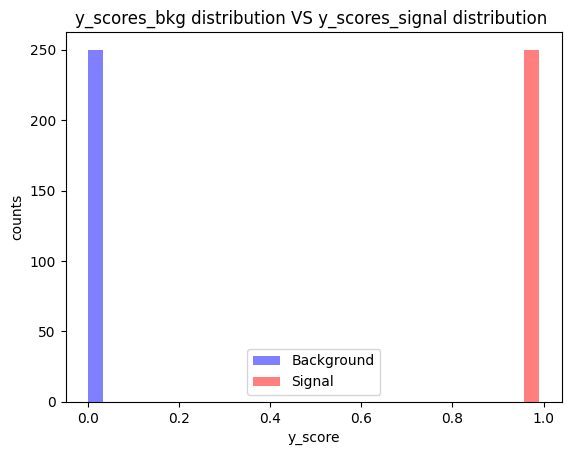

In [ ]:
# Plot signal and background distributions for the predicted scores with normalized counts and log scale

num_bins = 30  # Number of bins

# Compute the range for the bins based on the minimum and maximum values of the data
min_value = min(min(y_pred_prob[y_test_arr == 0]), min(y_pred_prob[y_test_arr == 1]))
max_value = max(max(y_pred_prob[y_test_arr == 0]), max(y_pred_prob[y_test_arr == 1]))
bin_range = (min_value, max_value)

counts, bins, _ = plt.hist(y_pred_prob[y_test_arr == 0], bins=num_bins, range=bin_range,  weights=w_test[y_test_arr==0], alpha=0.5, color='b', label='Background')
counts2, bins2, _ = plt.hist(y_pred_prob[y_test_arr == 1], bins=num_bins, range=bin_range,weights=w_test[y_test_arr==0], alpha=0.5, color='r', label='Signal')

print(counts)
print(counts2)

plt.xlabel('y_score')
plt.ylabel('counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

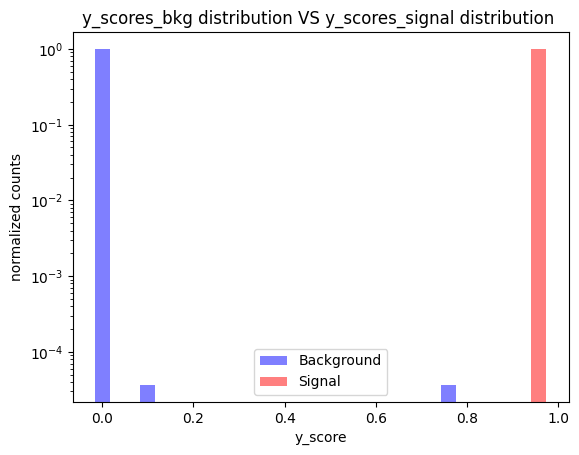

In [ ]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.yscale('log')
plt.legend()
plt.show()